### Data loading

In [ ]:
!pip install yfinance -q
!pip install --upgrade curl_cffi -q

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader

In [ ]:
def calculate_rsi(series, window=14):
    """
    Compute Relative Strength Index (RSI) for a given window.
    """
    delta = series.diff(1)
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def calculate_atr(high, low, close, window=14):
    """Calculates Average True Range (ATR)."""
    high_low = high - low
    high_close = np.abs(high - close.shift(1))
    low_close = np.abs(low - close.shift(1))
    tr = pd.DataFrame({'hl': high_low, 'hc': high_close, 'lc': low_close}).max(axis=1)
    atr = tr.ewm(com=window - 1, min_periods=window).mean()
    return atr

In [ ]:
from requests.cookies import create_cookie
import yfinance.data as _data

def _wrap_cookie(cookie, session):
    """
    If cookie is just a str (cookie name), look up its value
    in session.cookies and wrap it into a real Cookie object.
    """
    if isinstance(cookie, str):
        value = session.cookies.get(cookie)
        return create_cookie(name=cookie, value=value)
    return cookie

def patch_yfdata_cookie_basic():
    """
    Monkey-patch YfData._get_cookie_basic so that
    it always returns a proper Cookie object,
    even when response.cookies is a simple dict.
    """
    original = _data.YfData._get_cookie_basic

    def _patched(self, timeout=30):
        cookie = original(self, timeout)
        return _wrap_cookie(cookie, self._session)

    _data.YfData._get_cookie_basic = _patched

In [ ]:
def get_stock_features(ticker_symbol, dates, lookback=20):
    """
    Fetch historical data with using curl_cffi
    to avoid rate limiting issues.
    """
    try:
        from curl_cffi import requests

        patch_yfdata_cookie_basic()

        # Convert dates to datetime and ensure coverage for lookback periods
        dates = pd.to_datetime(dates).tz_localize(None)
        start_date = dates.min() - pd.Timedelta(days=lookback + 2)
        end_date = dates.max() + pd.Timedelta(days=1)

        # Create a session that impersonates Chrome
        session = requests.Session(impersonate="chrome")

        # Fetch historical data using the impersonated session
        ticker = yf.Ticker(ticker_symbol, session=session)
        data = ticker.history(start=start_date, end=end_date)

        data.index = data.index.tz_localize(None)

        # ===== Calculate features =====
        data['RSI'] = calculate_rsi(data['Close'], window=lookback)  # RSI

        # params
        bb_std = 2
        kc_lookback = 20
        kc_mult = 1.5

        # Bollinger Bands
        m_avg = data['Close'].rolling(window=lookback).mean()
        m_std = data['Close'].rolling(window=lookback).std()
        upper_BB = m_avg + bb_std * m_std
        lower_BB = m_avg - bb_std * m_std

        # Keltner's channels
        atr = calculate_atr(data['High'], data['Low'], data['Close'])
        kc_m_avg = data['Close'].ewm(span=kc_lookback, adjust=False).mean()
        upper_KC = kc_m_avg + (atr * kc_mult)
        lower_KC = kc_m_avg - (atr * kc_mult)

        # Squeeze Condition
        # Squeeze is ON when Bollinger Bands are inside Keltner Channels
        data['Squeeze_On'] = ((upper_BB > lower_KC) & (upper_BB < upper_KC)).astype(int) # 1 if squeeze is on, 0 otherwise


        # Keep only the required dates (after lookback)
        data = data[data.index >= dates.min()]

        return data[['Close', 'RSI', 'Volume', 'Squeeze_On']]

    except ImportError:
        print("curl_cffi not installed. Installing now...")
        import subprocess
        subprocess.check_call(["pip", "install", "curl_cffi"])
        print("curl_cffi installed. Please run your code again.")
        return None
    except Exception as e:
        print(f"Error fetching data: {e}")
        return None

In [ ]:
ticker = "SPY"
# Last 10 years
dates = ['2015-01-01', '2025-01-01']
df = get_stock_features(ticker, dates)

In [ ]:
df

,Close,RSI,Volume,Squeeze_On
Date,,,,
2015-01-02,172.075226,NaN,121465900,0
2015-01-05,168.967667,NaN,169632600,0
2015-01-06,167.376144,NaN,209151400,0
2015-01-07,169.461807,NaN,125346700,0
2015-01-08,172.468887,55.644962,147217800,0
...,...,...,...,...
2024-12-24,599.496582,54.178139,33160100,0
2024-12-26,599.536499,52.048132,41219100,0
2024-12-27,593.225464,48.716273,64969300,0


Remove rows with NaN due to the data pre-processing (RSI calculation)

In [ ]:
df = df.dropna().reset_index()
df

,Date,Close,RSI,Volume,Squeeze_On
0,2015-01-08,172.468887,55.644962,147217800,0
1,2015-01-09,171.086853,53.080153,158567300,0
2,2015-01-12,169.746582,49.423631,144396100,0
3,2015-01-13,169.269180,53.405716,214553300,0
4,2015-01-14,168.247269,53.648560,192991100,0
...,...,...,...,...,...
2507,2024-12-24,599.496582,54.178139,33160100,0
2508,2024-12-26,599.536499,52.048132,41219100,0
2509,2024-12-27,593.225464,48.716273,64969300,0
2510,2024-12-30,586.455811,41.641453,56578800,0


In [ ]:
split = 0.7

# Split into train/test
i_split = int(len(df) * split)
data_train = df.values[:i_split]
data_test = df.values[i_split:]

In [ ]:
data_train[0]

array([Timestamp('2015-01-08 00:00:00'), 172.46888732910156,
       55.64496209306259, 147217800, 0], dtype=object)

In [ ]:
data_test[0]

array([Timestamp('2021-12-31 00:00:00'), 453.1864929199219,
       61.70025861392156, 65237400, 0], dtype=object)

In [ ]:
def timestamp_to_unix(dataset):
  dataset = dataset.copy()
  for row in dataset:
    if isinstance(row[0], pd.Timestamp):
      row[0] = row[0].timestamp()

  return dataset.astype(np.float32)

In [ ]:
data_train = timestamp_to_unix(data_train)
data_test = timestamp_to_unix(data_test)

In [ ]:
data_train[0]

array([1.4206752e+09, 1.7246889e+02, 5.5644962e+01, 1.4721779e+08,
       0.0000000e+00], dtype=float32)

Now, let's create some sequences to train on (since this is time series data)

In [ ]:
def create_sequences(data, sequence_length=20):
  sequences = []
  for i in range(len(data) - sequence_length + 1):
    sequences.append(data[i:i+sequence_length])
  return np.array(sequences).astype(float)

In [ ]:
train_sequences = create_sequences(data_train)
test_sequences = create_sequences(data_test)

In [ ]:
# Split the test data into validation and test data
val_sequences, test_sequences = np.array_split(test_sequences,2)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

def normalize_sequences(sequences, mode='min-max'):
    normalized = []
    record_params = []  # Stores parameters for each sequence and feature

    for seq in sequences:
        num_features = seq.shape[1]
        normalized_seq = np.zeros_like(seq)
        params = []

        # Loop over all features including timestamp (col 0)
        for col in range(num_features):
            # Normalize ALL columns including timestamp
            # (using first n-1 time steps to avoid leakage)
            feature_data = seq[:-1, col]
            all_data = seq[:, col]

            if mode == 'zscore':
                mean = np.mean(feature_data)
                std = np.std(feature_data)
                std = std if std != 0 else 1.0  # Avoid division by zero
                normalized_feature = (all_data - mean) / std
                normalized_seq[:, col] = normalized_feature
                params.append((mean, std))  # Save mean/std for each feature
            else:
                scaler = MinMaxScaler()
                # Fit on all but last step to avoid leakage
                scaler.fit(feature_data.reshape(-1, 1))
                # Transform all data
                normalized_seq[:, col] = scaler.transform(all_data.reshape(-1, 1)).ravel()
                params.append(scaler)  # Save scaler for inverse transform later

        normalized.append(normalized_seq)
        record_params.append(params)

    return np.array(normalized), record_params

In [ ]:
train_normalized, train_params = normalize_sequences(train_sequences)
val_normalized, val_params = normalize_sequences(val_sequences)
test_normalized, test_params = normalize_sequences(test_sequences)

In [ ]:
np.array(train_params).shape

(1739, 5)

In [ ]:
train_normalized[0][0]

array([0.        , 0.97174622, 0.99969787, 0.45051799, 0.        ])

In [ ]:
# Look at all the normalized prices from the first test sequence set
test_normalized[0, :, 1]

array([0.15384763, 0.22285841, 0.07780121, 0.        , 0.20791111,
       0.21758306, 0.2931846 , 0.5204396 , 0.54285644, 0.51384609,
       0.36131799, 0.31252712, 0.36131799, 0.48439637, 0.64087893,
       0.79648273, 0.78417311, 0.85274725, 1.        , 1.04439565])

Now that we have the data and have normalized the price column, let's create the dataset and dataloaders. Instead of predicting the price at t, let's predict the return **(Price(T) - Price(T-1))/Price(T-1)**

In [ ]:
class ReturnSequenceDataset(torch.utils.data.Dataset):
  def __init__(self, normalized_data_sequences, raw_data_sequences):
      self.normalized_data = torch.tensor(normalized_data_sequences[:, :-1, :], dtype=torch.float32) # Input: First N-1 steps
      self.raw_data_sequences = raw_data_sequences

      targets = []
      for seq in raw_data_sequences:
          # seq is (SEQUENCE_LENGTH, num_features)
          price_t = seq[-1][1] # Price at the end of the window (target day)
          price_t_minus_1 = seq[-2][1] # Price on the previous day
          if price_t_minus_1 == 0: # Avoid division by zero
              daily_return = 0.0
          else:
              daily_return = (price_t - price_t_minus_1) / price_t_minus_1
          targets.append(daily_return)
          # print("price t: ", price_t)
          # print("price t-1: ", price_t_minus_1)
          # print("daily return: ", daily_return)
          # print("====================")
      self.targets = torch.tensor(targets, dtype=torch.float32).squeeze()

  def __len__(self):
      return len(self.normalized_data)

  def __getitem__(self, idx):
      return self.normalized_data[idx], self.targets[idx]

In [ ]:
train_dataset = ReturnSequenceDataset(train_normalized, train_sequences)
val_dataset = ReturnSequenceDataset(val_normalized, val_sequences)
test_dataset = ReturnSequenceDataset(test_normalized, test_sequences)

**Sanity Check!** The return as the target should be the (last price - 2nd to last price)/(2nd to last price) in the raw price sequence

In [ ]:
# This shows the sequence of returns
train_sequences[0][:, 1]

array([172.46888733, 171.08685303, 169.74658203, 169.2691803 ,
       168.24726868, 166.70602417, 168.89230347, 169.25241089,
       170.10684204, 172.63644409, 171.68994141, 172.09197998,
       169.82202148, 167.64413452, 169.19380188, 167.06614685,
       169.13514709, 171.58105469, 170.9276886 , 172.65322876])

In [ ]:
# The target should match above return
train_dataset[0]

(tensor([[0.0000, 0.9717, 0.9997, 0.4505, 0.0000],
         [0.0370, 0.7387, 0.8541, 0.5431, 0.0000],
         [0.1481, 0.5127, 0.6465, 0.4275, 0.0000],
         [0.1852, 0.4322, 0.8726, 1.0000, 0.0000],
         [0.2222, 0.2599, 0.8864, 0.8240, 0.0000],
         [0.2593, 0.0000, 0.8639, 0.6904, 0.0000],
         [0.2963, 0.3687, 0.7620, 0.9782, 0.0000],
         [0.4444, 0.4294, 0.3154, 0.3181, 0.0000],
         [0.4815, 0.5735, 0.3319, 0.2524, 0.0000],
         [0.5185, 1.0000, 0.5504, 0.6720, 0.0000],
         [0.5556, 0.8404, 0.4250, 0.2081, 0.0000],
         [0.6667, 0.9082, 0.4701, 0.0000, 0.0000],
         [0.7037, 0.5254, 0.1968, 0.3430, 0.0000],
         [0.7407, 0.1582, 0.0000, 0.6243, 0.0000],
         [0.7778, 0.4195, 0.2440, 0.6657, 1.0000],
         [0.8148, 0.0607, 0.2128, 0.8627, 1.0000],
         [0.9259, 0.4096, 0.4265, 0.5802, 1.0000],
         [0.9630, 0.8220, 0.9084, 0.2628, 1.0000],
         [1.0000, 0.7119, 1.0000, 0.3452, 1.0000]]),
 tensor(0.0101))

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
sample = next(iter(test_loader))

In [ ]:
# Look at the shapes for the inputs and targets
X, y = sample
print(X[0], y[0])
X.shape, y.shape

tensor([[0.0000, 0.1538, 0.4053, 0.6126, 0.0000],
        [0.0370, 0.2229, 1.0000, 0.5247, 0.0000],
        [0.0741, 0.0778, 0.9628, 0.8219, 0.0000],
        [0.1852, 0.0000, 0.5836, 0.5550, 0.0000],
        [0.2222, 0.2079, 0.5502, 0.5549, 0.0000],
        [0.2593, 0.2176, 0.5535, 0.5940, 0.0000],
        [0.2963, 0.2932, 0.9209, 0.4865, 0.0000],
        [0.3333, 0.5204, 0.9772, 1.0000, 0.0000],
        [0.4444, 0.5429, 0.6936, 0.0000, 0.0000],
        [0.5185, 0.5138, 0.7144, 0.3553, 0.0000],
        [0.5556, 0.3613, 0.2277, 0.6636, 0.0000],
        [0.5926, 0.3125, 0.2701, 0.7387, 0.0000],
        [0.7037, 0.3613, 0.1736, 0.4111, 0.0000],
        [0.7407, 0.4844, 0.3063, 0.4391, 0.0000],
        [0.7778, 0.6409, 0.2858, 0.8198, 0.0000],
        [0.8148, 0.7965, 0.3289, 0.5495, 0.0000],
        [0.8519, 0.7842, 0.2642, 0.5125, 0.0000],
        [0.9630, 0.8527, 0.0000, 0.2757, 0.0000],
        [1.0000, 1.0000, 0.4128, 0.6648, 0.0000]]) tensor(0.0022)


(torch.Size([32, 19, 5]), torch.Size([32]))

### Evaluation Code

#### Helper functions to do things like denormalize the predicted **prices**

In [ ]:
def get_validation_predictions(model, dataloader, device):
  model.eval()
  val_predictions = []
  with torch.no_grad():
    for inputs, _ in dataloader:
      inputs = inputs.to(device)
      outputs = model(inputs)
      val_predictions.extend(outputs.cpu().numpy())
  return np.array(val_predictions)

In [ ]:
def get_denorm_preds(norm_preds, price_min, price_max):
  denorm_preds = []
  for idx, price in enumerate(norm_preds):
    denorm_price = price * (price_max[idx] - price_min[idx]) + price_min[idx]
    denorm_preds.append(denorm_price)
  return np.array(denorm_preds)

In [ ]:
def undo_zscore(norm_preds, price_mean, price_std):
  denorm_preds = []
  for idx, price in enumerate(norm_preds):
    denorm_price = price * price_std[idx] + price_mean[idx]
    denorm_preds.append(denorm_price)
  return np.array(denorm_preds)

In [ ]:
def get_true_preds(dataloader):
  y_true = []
  for _, targets in dataloader:
    y_true.extend(targets.cpu().numpy())
  return y_true

In [ ]:
from sklearn.metrics import mean_squared_error

In [ ]:
def MSE(y_true, y_pred):
  return mean_squared_error(y_true, y_pred)

def MPA(y_true, y_pred):
  return 1 - np.mean(np.abs(y_true - y_pred)/y_true)

def calculate_mda(y_true, y_pred):
  # np.diff calculates the difference between consecutive elements
  true_direction = np.diff(y_true) > 0

  pred_direction = np.diff(y_pred) > 0

  direction_accuracy = np.mean(true_direction == pred_direction) * 100

  return direction_accuracy

In [ ]:
def get_predicted_returns(model, dataloader, device):
    model.eval()
    pred_returns_list = []
    with torch.no_grad():
        for inputs, _ in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs) # model predicts returns
            pred_returns_list.extend(outputs.cpu().numpy())
    return np.array(pred_returns_list)

def get_true_returns(dataloader):
    true_returns_list = []
    for _, targets in dataloader: # targets are already returns
        true_returns_list.extend(targets.cpu().numpy())
    return np.array(true_returns_list)

def reconstruct_prices(pred_returns, raw_sequences):
    # raw_sequences: (num_samples, SEQUENCE_LENGTH, num_features)

    actual_target_prices = []
    predicted_target_prices = []

    for i in range(len(raw_sequences)):
        seq_raw = raw_sequences[i] # (SEQUENCE_LENGTH, num_features)

        # Last known actual price (price at t-1) from the raw sequence
        last_known_raw_price = seq_raw[-2][1]

        # Actual target price (price at t) from the raw sequence
        actual_target_raw_price = seq_raw[-1][1]
        actual_target_prices.append(actual_target_raw_price)

        # Reconstruct predicted price
        # pred_returns[i] is the predicted return for this sequence
        reconstructed_pred_price = last_known_raw_price * (1 + pred_returns[i])
        predicted_target_prices.append(reconstructed_pred_price)

    return np.array(predicted_target_prices), np.array(actual_target_prices)


### Transformer Model

In [ ]:
import torch
from torch import nn
import numpy as np
import math

def t2v(tau, f, out_features, w, b, w0, b0):
    # k-1 periodic features
    v1 = f(torch.matmul(tau, w) + b)
    # One Non-periodic feature
    v2 = torch.matmul(tau, w0) + b0
    return torch.cat([v1, v2], dim=-1)

class SineActivation(nn.Module):
    def __init__(self, in_features, out_features):
        super(SineActivation, self).__init__()
        self.out_features = out_features
        self.w0 = nn.parameter.Parameter(torch.randn(in_features, 1))
        self.b0 = nn.parameter.Parameter(torch.randn(1))
        self.w = nn.parameter.Parameter(torch.randn(in_features, out_features-1))
        self.b = nn.parameter.Parameter(torch.randn(out_features-1))
        self.f = torch.sin

    def forward(self, tau):
        return t2v(tau, self.f, self.out_features, self.w, self.b, self.w0, self.b0)

In [ ]:
import math
import torch.nn.functional as F

class PositionalEncoding(nn.Module):
    """
    Standard positional encoding from the "Attention Is All You Need" paper.
    Adds sinusoidal positional embeddings so the model can learn order information.
    """
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() *
                             (-math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        x shape: (seq_len, batch_size, d_model)
        """
        seq_len = x.size(0)
        # Add positional encoding
        x = x + self.pe[:seq_len, : , :]
        return self.dropout(x)

In [ ]:
class TransformerDecoderTimeSeriesModel(nn.Module):
  """
  A Transformer Decoder-based model for time-series forecasting.
  Uses causal self-attention.
  """
  def __init__(
      self,
      time2vec_dim=2,
      input_dim=6, # Number of input features before Time2Vec split
      d_model=128, # Model dimension
      nhead=8, # Number of attention heads
      num_layers=4, # Number of TransformerDecoder layers
      dim_feedforward=512, # Dim of feedforward network
      dropout=0.3,
  ):
      super().__init__()
      self.d_model = d_model

      # 1. Time2Vec for timestamp encoding (feature 0)
      self.time2vec = SineActivation(in_features=1, out_features=time2vec_dim)

      # 2. New input dimension after concatenating T2V(time) + other features
      new_input_dim = (input_dim - 1) + time2vec_dim

      # 3. Project concatenated features to transformer dimension (d_model)
      self.input_projection = nn.Linear(new_input_dim, d_model)

      # 4. Positional encoding
      self.pos_encoder = PositionalEncoding(d_model, dropout=dropout)

      # 5. Transformer Decoder Layers
      decoder_layer = nn.TransformerDecoderLayer(
          d_model=d_model,
          nhead=nhead,
          dim_feedforward=dim_feedforward,
          dropout=dropout,
          batch_first=False # (seq_len, batch, features)
      )
      self.transformer_decoder = nn.TransformerDecoder(
          decoder_layer,
          num_layers=num_layers
      )

      # 6. Prediction Head
      self.dropout1 = nn.Dropout(dropout)
      self.fc1 = nn.Linear(d_model, d_model // 2)
      self.dropout2 = nn.Dropout(dropout)
      self.fc2 = nn.Linear(d_model // 2, 1) # Output a single value

      self._reset_parameters()

  def _reset_parameters(self):
      """Initiate parameters in the transformer model."""
      for p in self.parameters():
          if p.dim() > 1:
              nn.init.xavier_uniform_(p)

  def _generate_causal_mask(self, sz, device):
      """Generates a causal mask for the decoder."""
      mask = (torch.triu(torch.ones(sz, sz, device=device)) == 1).transpose(0, 1)
      mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
      return mask

  def forward(self, src):
      """
      src shape expected: (batch_size, seq_len, input_dim)
      """
      batch_size, seq_len, _ = src.shape
      device = src.device

      # 1. Separate timestamp, apply Time2Vec, concatenate
      src_time = src[:, :, 0].unsqueeze(-1)  # (batch, seq_len, 1)
      src_rest = src[:, :, 1:] # (batch, seq_len, input_dim-1)
      src_time_embed = self.time2vec(src_time) # (batch, seq_len, time2vec_dim)
      src_combined = torch.cat([src_time_embed, src_rest], dim=-1) # (batch, seq_len, new_input_dim)

      # 2. Project to d_model and permute for Transformer: (seq_len, batch_size, d_model)
      src_proj = self.input_projection(src_combined).permute(1, 0, 2) # (seq_len, batch, d_model)

      # 3. Add positional encoding
      src_pos = self.pos_encoder(src_proj) # (seq_len, batch, d_model)

      # 4. Generate causal mask for self-attention
      tgt_mask = self._generate_causal_mask(seq_len, device=device)

      # 5. Pass through Transformer Decoder
      memory = src_pos
      output = self.transformer_decoder(tgt=src_pos, memory=memory, tgt_mask=tgt_mask, memory_mask=None)
      # output shape: (seq_len, batch_size, d_model)

      # 6. Prediction Head
      # Use the output corresponding to the last input time step for prediction
      output = output[-1, :, :] # Select last time step: (batch_size, d_model)
      output = self.dropout1(output)
      output = F.relu(self.fc1(output))
      output = self.dropout2(output)
      output = self.fc2(output).squeeze(-1) # (batch_size)

      return output

### Loss function

In [ ]:
class GalformerLoss(nn.Module):
    def __init__(self, eps=1e-8, trend_penalty_weight=1.0):
        super(GalformerLoss, self).__init__()
        self.eps = eps
        self.trend_penalty_weight = trend_penalty_weight

    def forward(self, y_pred, y_true, last_price):
        """
        MSE with direction penalty

        Args:
            y_pred (Tensor): Predicted values, shape [batch]
            y_true (Tensor): True target values, shape [batch]
            last_price (Tensor): Last known price value, shape [batch]
        """
        # Standard MSE part
        mse = torch.mean((y_pred - y_true) ** 2)

        # Compute scaling factor: 10^(floor(log10(mse)))
        mse_abs = torch.clamp(mse, min=self.eps)
        log_val = torch.floor(torch.log10(mse_abs))
        scaling = torch.pow(10.0, log_val)

        # Trend accuracy based on sign of returns
        true_trend_sign = torch.sign(y_true)
        pred_trend_sign = torch.sign(y_pred)

        # Calculate trend accuracy as the percentage of correct trend predictions.
        correct_trend = (pred_trend_sign == true_trend_sign).float()
        trend_acc = correct_trend.mean()

        loss = mse + self.trend_penalty_weight * (1 - trend_acc) * scaling
        return loss

### Hyperparameter tuning

In [ ]:
!pip install optuna -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 21.7 MB/s eta 0:00:00


In [ ]:
train_loader.dataset[0][0].shape

torch.Size([19, 5])

In [ ]:
import optuna

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"


def eval_galformer(model, loader):
    """Return mean GalformerLoss over a DataLoader."""
    model.eval()
    loss_fn = GalformerLoss()
    total, n_batches = 0.0, 0
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            preds  = model(xb)
            total += loss_fn(preds, yb, xb[:, -1, 1]).item()
            n_batches += 1
    return total / n_batches

def objective(trial: optuna.Trial) -> float:
    d_model = trial.suggest_categorical("d_model", [32, 64, 128, 256, 512])
    # d_model must be divisible by nheads
    valid_heads = [h for h in [2, 4, 6, 8] if d_model % h == 0]
    nhead = trial.suggest_categorical("nhead", valid_heads)

    time2vec_dim = trial.suggest_categorical("time2vec_dim", [2, 4, 8, 16])
    num_layers = trial.suggest_int("num_layers", 1, 4)
    dim_feedforward = trial.suggest_int("ff_dim", 2*d_model, 4*d_model, step=d_model)
    dropout = trial.suggest_float("dropout", 0.05, 0.4)
    lr = trial.suggest_float("lr", 1e-5, 1e-3, log=True)

    model = TransformerDecoderTimeSeriesModel(
      time2vec_dim=time2vec_dim,
      input_dim       = train_loader.dataset[0][0].shape[-1],
      d_model         = d_model,
      nhead           = nhead,
      num_layers      = num_layers,
      dim_feedforward = dim_feedforward,
      dropout         = dropout
    ).to(DEVICE)

    optimizer  = torch.optim.AdamW(model.parameters(), lr=lr)
    loss_fn= GalformerLoss()

    EPOCHS = 15
    eval_every = 3

    # Training & evaluation
    for epoch in range(1, EPOCHS + 1):
        model.train()
        for xb, yb in train_loader:
          xb, yb = xb.to(DEVICE), yb.to(DEVICE)
          optimizer.zero_grad()
          preds = model(xb)
          loss  = loss_fn(preds, yb, xb[:, -1, 1])
          loss.backward()
          optimizer.step()

        # intermediate evaluation / pruning
        if epoch % eval_every == 0 or epoch == EPOCHS:
          val_loss = eval_galformer(model, val_loader)
          trial.report(val_loss, step=epoch)
          if trial.should_prune():
              raise optuna.TrialPruned()
    return val_loss

In [ ]:
study = optuna.create_study(direction="minimize",
                                sampler=optuna.samplers.TPESampler(),
                                pruner=optuna.pruners.MedianPruner())
study.optimize(objective, n_trials=100, timeout=60*60)

print("Best hyper‑parameters:", study.best_params)
study.trials_dataframe().to_csv("optuna_trials.csv", index=False)

[I 2025-05-13 14:00:11,714] A new study created in memory with name: no-name-ef8fc6f9-5968-4d1b-b41e-f9dd4eecbb61
[I 2025-05-13 14:00:21,871] Trial 0 finished with value: 0.001532281744099843 and parameters: {'d_model': 256, 'nhead': 8, 'time2vec_dim': 2, 'num_layers': 2, 'ff_dim': 768, 'dropout': 0.27524633045615504, 'lr': 5.9886554391065745e-05}. Best is trial 0 with value: 0.001532281744099843.
[I 2025-05-13 14:00:28,685] Trial 1 finished with value: 0.00021684333175168527 and parameters: {'d_model': 128, 'nhead': 2, 'time2vec_dim': 4, 'num_layers': 1, 'ff_dim': 512, 'dropout': 0.09466179229915966, 'lr': 0.00019753337241403161}. Best is trial 1 with value: 0.00021684333175168527.
[I 2025-05-13 14:00:41,945] Trial 2 finished with value: 0.0003692474250177232 and parameters: {'d_model': 128, 'nhead': 2, 'time2vec_dim': 8, 'num_layers': 3, 'ff_dim': 384, 'dropout': 0.28495791613158006, 'lr': 0.0004807566222221721}. Best is trial 1 with value: 0.00021684333175168527.
[I 2025-05-13 14:00

Best hyper‑parameters: {'d_model': 128, 'nhead': 2, 'time2vec_dim': 4, 'num_layers': 3, 'ff_dim': 384, 'dropout': 0.11319891654973303, 'lr': 0.0006985547726970089}


In [ ]:
from plotly.io import show

fig = optuna.visualization.plot_param_importances(study)
show(fig)

### Training

In [ ]:
# Define constants from best hyperparameters
D_MODEL = 128
NHEAD = 2
TIME2VEC_DIM = 4
NUM_LAYERS = 3
FF_DIM = 384
DROPOUT = 0.11319891654973303
LEARNING_RATE = 0.0006985547726970089

# Create model with best hyperparameters
transformer = TransformerDecoderTimeSeriesModel(
    time2vec_dim=TIME2VEC_DIM,
    input_dim=train_loader.dataset[0][0].shape[-1],
    d_model=D_MODEL,
    nhead=NHEAD,
    num_layers=NUM_LAYERS,
    dim_feedforward=FF_DIM,
    dropout=DROPOUT
).to(DEVICE)

# Define optimizer with best learning rate
optimizer = torch.optim.AdamW(transformer.parameters(), lr=LEARNING_RATE)

# Define loss function
loss_fn = GalformerLoss()

epochs = 1000
best_loss = float('inf')
patience = 25  # For early stopping
patience_counter = 0

# Lists to track metrics
train_losses = []
val_losses = []

# Training loop
for epoch in range(epochs):
    # Training phase
    transformer.train()
    total_train_loss = 0.0

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

        optimizer.zero_grad()
        outputs = transformer(inputs)
        loss = loss_fn(outputs, targets, inputs[:, -1, 1])
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation phase
    transformer.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            outputs = transformer(inputs)
            val_loss = loss_fn(outputs, targets, inputs[:, -1, 1])
            total_val_loss += val_loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    # Print progress
    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.6f} | Val Loss: {avg_val_loss:.6f}")

    # Save best model
    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        torch.save(transformer.state_dict(), 'best_transformer_model.pt')
        patience_counter = 0
        print(f"Model saved with val loss: {best_loss:.6f}")
    else:
        patience_counter += 1

    # Early stopping
    if patience_counter >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

Epoch 1/1000 | Train Loss: 0.370529 | Val Loss: 0.001275
Model saved with val loss: 0.001275
Epoch 2/1000 | Train Loss: 0.010468 | Val Loss: 0.000286
Model saved with val loss: 0.000286
Epoch 3/1000 | Train Loss: 0.003351 | Val Loss: 0.000239
Model saved with val loss: 0.000239
Epoch 4/1000 | Train Loss: 0.001820 | Val Loss: 0.000214
Model saved with val loss: 0.000214
Epoch 5/1000 | Train Loss: 0.001119 | Val Loss: 0.000223
Epoch 6/1000 | Train Loss: 0.000744 | Val Loss: 0.000219
Epoch 7/1000 | Train Loss: 0.000607 | Val Loss: 0.000215
Epoch 8/1000 | Train Loss: 0.000455 | Val Loss: 0.000214
Epoch 9/1000 | Train Loss: 0.000495 | Val Loss: 0.000214
Model saved with val loss: 0.000214
Epoch 10/1000 | Train Loss: 0.000377 | Val Loss: 0.000214
Epoch 11/1000 | Train Loss: 0.000349 | Val Loss: 0.000213
Model saved with val loss: 0.000213
Epoch 12/1000 | Train Loss: 0.000303 | Val Loss: 0.000218
Epoch 13/1000 | Train Loss: 0.000287 | Val Loss: 0.000218
Epoch 14/1000 | Train Loss: 0.000306 | 

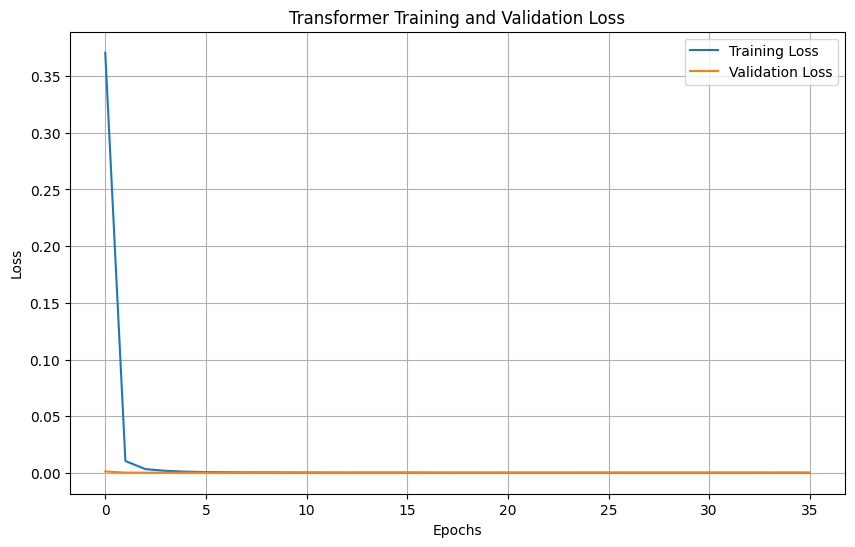

In [ ]:
# Plot loss curves
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Transformer Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.savefig('training_curves.png')
plt.show()

### Evaluate the transformer

Load the best model parameters and get the predictions on the test set

In [ ]:
transformer.load_state_dict(torch.load('best_transformer_model.pt'))

<All keys matched successfully>

In [ ]:
best_loss

0.00021318314793461468

In [ ]:
pred_returns_test = get_predicted_returns(transformer, test_loader, DEVICE)
pred_returns_test

array([-1.9977830e-05, -2.1930406e-05, -2.2857741e-05, -2.4269830e-05,
       -2.3446890e-05, -2.3670305e-05, -2.2961161e-05, -2.2368811e-05,
       -2.4047520e-05, -2.3222092e-05, -2.3143220e-05, -2.0241350e-05,
       -2.2096589e-05, -1.8938881e-05, -2.0229869e-05, -1.8195831e-05,
       -1.8009843e-05, -1.7932893e-05, -1.8836523e-05, -2.0628286e-05,
       -1.9730112e-05, -2.0456020e-05, -2.1201748e-05, -2.0348845e-05,
       -2.1575150e-05, -2.0136999e-05, -1.9666593e-05, -1.7294165e-05,
       -1.6772377e-05, -2.2752414e-05, -2.2377586e-05, -2.2340042e-05,
       -2.2278415e-05, -2.2224587e-05, -2.2126216e-05, -2.0445630e-05,
       -1.9771469e-05, -2.0439125e-05, -1.9981831e-05, -1.8358798e-05,
       -1.8760693e-05, -1.9661224e-05, -1.8717576e-05, -2.2248772e-05,
       -2.2037071e-05, -2.0004562e-05, -2.0008054e-05, -2.0830485e-05,
       -2.2078166e-05, -2.1168220e-05, -1.9720348e-05, -1.9091414e-05,
       -1.8260238e-05, -1.9057465e-05, -1.9704268e-05, -2.0325009e-05,
      

In [ ]:
true_returns_test = get_true_returns(test_loader)
true_returns_test

array([ 2.2237441e-03, -6.6345395e-03,  0.0000000e+00,  4.4673276e-03,
        2.7300152e-03,  1.5384186e-04, -6.6300924e-03,  9.7902939e-03,
        1.9040443e-03, -2.8615221e-03, -1.3910847e-02, -2.8658730e-03,
       -4.5227720e-03,  8.7285498e-03, -4.3486198e-03, -6.6852793e-03,
        3.5901237e-04, -5.8305438e-04,  5.5198530e-03, -1.1648732e-02,
       -7.3381942e-03, -7.6199509e-03,  4.8149686e-04,  6.5061320e-03,
       -2.7085925e-03,  1.1137778e-02, -1.3859066e-02,  7.0497282e-03,
        6.3414341e-03,  1.4454650e-02,  4.1189617e-03, -1.4634205e-03,
        1.8651640e-03, -4.3219770e-03, -6.7223511e-03, -3.0702672e-03,
        1.5060854e-03,  6.5766205e-03, -5.4855281e-03,  1.1658996e-03,
        8.6224088e-03, -1.2048318e-02,  5.8643974e-04, -2.0738242e-03,
       -9.1933310e-03, -1.6528329e-02, -2.2486215e-03,  4.2052278e-03,
       -1.4691231e-02,  3.9914632e-04,  5.7974770e-03, -2.4269037e-03,
       -3.9779796e-04, -1.3385987e-02,  7.2818864e-03, -3.7683692e-04,
      

In [ ]:
predicted_prices_test, true_prices_test = reconstruct_prices(
  pred_returns_test,
  test_sequences # The raw unnormalized sequences for the test set
)

Calculate some metrics

In [ ]:
mse = MSE(true_prices_test, predicted_prices_test)
mpa = MPA(true_prices_test, predicted_prices_test)
mda = calculate_mda(true_prices_test, predicted_prices_test)

print(f"Mean Squared Error: {mse}")
print(f"Mean Price Accuracy: {mpa}")
print(f"Mean Direction Accuracy: {mda}")

Mean Squared Error: 15.763760680415796
Mean Price Accuracy: 0.9941397496782935
Mean Direction Accuracy: 53.278688524590166


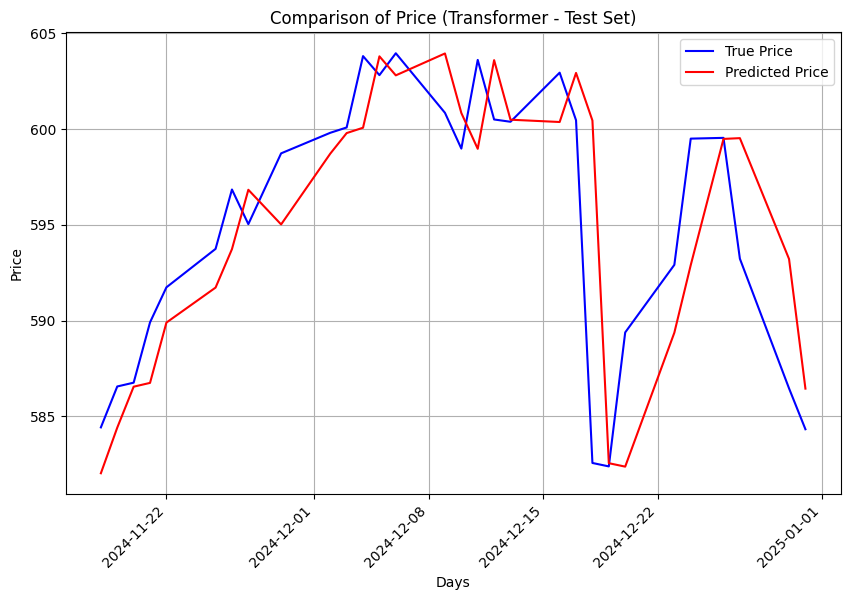

In [ ]:
import matplotlib.pyplot as plt

num_test_days = 30 #len(y_test_denorm)
x = df.loc[i_split:, 'Date'].tolist()[-num_test_days:] # gets the corresponding test dates

# Create the plot
plt.figure(figsize=(10, 6))  # Set figure size
plt.plot(x, true_prices_test[-num_test_days:], label='True Price', color='blue')
plt.plot(x, predicted_prices_test[-num_test_days:], label='Predicted Price', color='red')
plt.xticks(rotation=45, ha='right')

plt.title('Comparison of Price (Transformer - Test Set)')
plt.xlabel('Days')
plt.ylabel('Price')
plt.grid(True)
plt.legend()

plt.show()

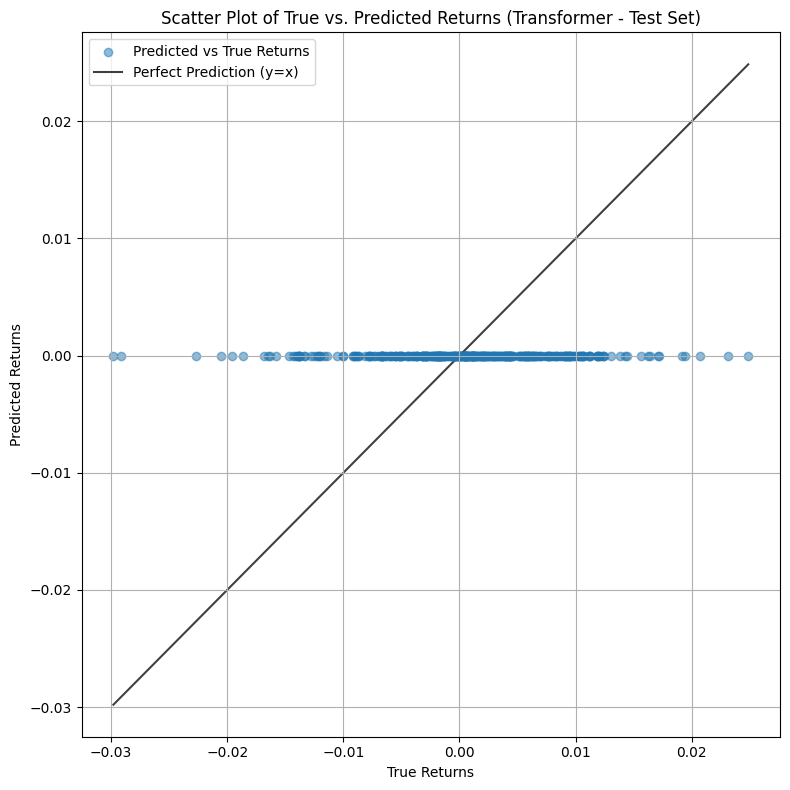

In [ ]:
# Ensure both are 1D NumPy arrays
true_returns_test = np.array(true_returns_test).flatten()
pred_returns_test = np.array(pred_returns_test).flatten()

plt.figure(figsize=(8, 8))
plt.scatter(true_returns_test, pred_returns_test, alpha=0.5, label='Predicted vs True Returns')

# Add a line for perfect correlation (y=x)
lims = [
    min(min(true_returns_test), min(pred_returns_test)),
    max(max(true_returns_test), max(pred_returns_test))
]
plt.plot(lims, lims, 'k-', alpha=0.75, zorder=0, label='Perfect Prediction (y=x)')

plt.xlabel("True Returns")
plt.ylabel("Predicted Returns")
plt.title("Scatter Plot of True vs. Predicted Returns (Transformer - Test Set)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### LSTM

In [ ]:
class LSTMTimeSeriesModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, num_layers=2, dropout=0.1):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout
        )
        self.head = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        # x: [batch, seq_len, input_dim]
        out, _ = self.lstm(x) # out: [batch, seq_len, hidden_dim]
        last = out[:, -1, :] # take final time step
        return self.head(last).squeeze(-1)  # [batch]

In [ ]:
def objective_lstm(trial: optuna.Trial) -> float:
  lstm_hidden_dim_opt = trial.suggest_categorical("lstm_hidden_dim", [32, 64, 128, 256])
  lstm_num_layers_opt = trial.suggest_int("lstm_num_layers", 1, 3)
  # Dropout for LSTM is applied between layers if num_layers > 1
  lstm_dropout_opt = trial.suggest_float("lstm_dropout", 0.0, 0.4) if lstm_num_layers_opt > 1 else 0.0
  lr_lstm_opt = trial.suggest_float("lr_lstm", 1e-4, 5e-3, log=True)

  model_lstm_opt = LSTMTimeSeriesModel(
      input_dim=train_loader.dataset[0][0].shape[-1],
      hidden_dim=lstm_hidden_dim_opt,
      num_layers=lstm_num_layers_opt,
      dropout=lstm_dropout_opt
  ).to(DEVICE)

  optimizer_lstm_opt = torch.optim.AdamW(model_lstm_opt.parameters(), lr=lr_lstm_opt)
  loss_fn_lstm_opt = GalformerLoss()

  EPOCHS_LSTM_OPT = 15
  eval_every_lstm_opt = 3

  for epoch_lstm_opt in range(1, EPOCHS_LSTM_OPT + 1):
      model_lstm_opt.train()
      for xb_l, yb_l in train_loader:
          xb_l, yb_l = xb_l.to(DEVICE), yb_l.to(DEVICE)
          optimizer_lstm_opt.zero_grad()
          preds_lstm_train = model_lstm_opt(xb_l)
          loss_lstm_train = loss_fn_lstm_opt(preds_lstm_train, yb_l, xb_l[:, -1, 1])
          loss_lstm_train.backward()
          optimizer_lstm_opt.step()

      if epoch_lstm_opt % eval_every_lstm_opt == 0 or epoch_lstm_opt == EPOCHS_LSTM_OPT:
          val_loss_lstm_opt = eval_galformer(model_lstm_opt, val_loader)
          trial.report(val_loss_lstm_opt, step=epoch_lstm_opt)
          if trial.should_prune():
              raise optuna.TrialPruned()
  return val_loss_lstm_opt

In [ ]:
study_lstm = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(), pruner=optuna.pruners.MedianPruner())
study_lstm.optimize(objective_lstm, n_trials=25, timeout=60*30)
print("Best LSTM hyper‑parameters:", study_lstm.best_params)

[I 2025-05-13 14:29:30,705] A new study created in memory with name: no-name-9d03083a-77cf-4b41-9ca9-9b16574ecd04
[I 2025-05-13 14:29:34,646] Trial 0 finished with value: 0.00021520347975941453 and parameters: {'lstm_hidden_dim': 256, 'lstm_num_layers': 2, 'lstm_dropout': 0.25930023538534597, 'lr_lstm': 0.0007400372539023299}. Best is trial 0 with value: 0.00021520347975941453.
[I 2025-05-13 14:29:37,270] Trial 1 finished with value: 0.00022661223374598194 and parameters: {'lstm_hidden_dim': 64, 'lstm_num_layers': 2, 'lstm_dropout': 0.08326693739434604, 'lr_lstm': 0.0025572530881776833}. Best is trial 0 with value: 0.00021520347975941453.
[I 2025-05-13 14:29:39,643] Trial 2 finished with value: 0.00021315891838942966 and parameters: {'lstm_hidden_dim': 128, 'lstm_num_layers': 1, 'lr_lstm': 0.0006077921009770735}. Best is trial 2 with value: 0.00021315891838942966.
[I 2025-05-13 14:29:42,612] Trial 3 finished with value: 0.00021299575079562297 and parameters: {'lstm_hidden_dim': 256, 'l

Best LSTM hyper‑parameters: {'lstm_hidden_dim': 256, 'lstm_num_layers': 1, 'lr_lstm': 0.0007211600340251226}


In [ ]:
fig_lstm = optuna.visualization.plot_param_importances(study_lstm)
show(fig_lstm)

In [ ]:
LSTM_HIDDEN_DIM = 256
LSTM_NUM_LAYERS = 2
LSTM_DROPOUT = 0.1
LSTM_LR = 0.0007211600340251226

lstm_model_final = LSTMTimeSeriesModel(
    input_dim=train_loader.dataset[0][0].shape[-1],
    hidden_dim=LSTM_HIDDEN_DIM,
    num_layers=LSTM_NUM_LAYERS,
    dropout=LSTM_DROPOUT
).to(DEVICE)

optimizer_lstm_final = torch.optim.AdamW(lstm_model_final.parameters(), lr=LSTM_LR)
loss_fn_lstm_final = GalformerLoss()

epochs_lstm_final = 1000
best_val_loss_lstm_final = float('inf')
patience_lstm_final = 25
patience_counter_lstm_final = 0
train_losses_lstm, val_losses_lstm = [], []

print("\nStarting LSTM final training...")
for epoch_lstm_idx in range(epochs_lstm_final):
    lstm_model_final.train()
    total_train_loss_lstm = 0.0
    for inputs_l_f, targets_l_f in train_loader:
        inputs_l_f, targets_l_f = inputs_l_f.to(DEVICE), targets_l_f.to(DEVICE)
        optimizer_lstm_final.zero_grad()
        outputs_l_f = lstm_model_final(inputs_l_f)
        loss_l_f = loss_fn_lstm_final(outputs_l_f, targets_l_f, inputs_l_f[:, -1, 1])
        loss_l_f.backward()
        optimizer_lstm_final.step()
        total_train_loss_lstm += loss_l_f.item()
    avg_train_loss_lstm = total_train_loss_lstm / len(train_loader)
    train_losses_lstm.append(avg_train_loss_lstm)

    lstm_model_final.eval()
    total_val_loss_lstm = 0.0
    with torch.no_grad():
        for inputs_val_l, targets_val_l in val_loader:
            inputs_val_l, targets_val_l = inputs_val_l.to(DEVICE), targets_val_l.to(DEVICE)
            outputs_val_l = lstm_model_final(inputs_val_l)
            val_loss_item_l = loss_fn_lstm_final(outputs_val_l, targets_val_l, inputs_val_l[:, -1, 1])
            total_val_loss_lstm += val_loss_item_l.item()
    avg_val_loss_lstm = total_val_loss_lstm / len(val_loader) if len(val_loader) > 0 else float('inf')
    val_losses_lstm.append(avg_val_loss_lstm)

    print(f"Epoch {epoch_lstm_idx+1}/{epochs_lstm_final} | LSTM Train Loss: {avg_train_loss_lstm:.6f} | LSTM Val Loss: {avg_val_loss_lstm:.6f}")

    if avg_val_loss_lstm < best_val_loss_lstm_final:
        best_val_loss_lstm_final = avg_val_loss_lstm
        torch.save(lstm_model_final.state_dict(), 'best_lstm_model.pt')
        patience_counter_lstm_final = 0
        print(f"LSTM model saved with val_loss: {best_val_loss_lstm_final:.6f}")
    else:
        patience_counter_lstm_final += 1
    if patience_counter_lstm_final >= patience_lstm_final:
        print(f"Early stopping LSTM at epoch {epoch_lstm_idx+1}")
        break
print("LSTM final training finished.")


Starting LSTM final training...
Epoch 1/1000 | LSTM Train Loss: 0.000283 | LSTM Val Loss: 0.000221
LSTM model saved with val_loss: 0.000221
Epoch 2/1000 | LSTM Train Loss: 0.000162 | LSTM Val Loss: 0.000214
LSTM model saved with val_loss: 0.000214
Epoch 3/1000 | LSTM Train Loss: 0.000158 | LSTM Val Loss: 0.000223
Epoch 4/1000 | LSTM Train Loss: 0.000158 | LSTM Val Loss: 0.000218
Epoch 5/1000 | LSTM Train Loss: 0.000157 | LSTM Val Loss: 0.000214
Epoch 6/1000 | LSTM Train Loss: 0.000157 | LSTM Val Loss: 0.000226
Epoch 7/1000 | LSTM Train Loss: 0.000155 | LSTM Val Loss: 0.000230
Epoch 8/1000 | LSTM Train Loss: 0.000158 | LSTM Val Loss: 0.000216
Epoch 9/1000 | LSTM Train Loss: 0.000157 | LSTM Val Loss: 0.000223
Epoch 10/1000 | LSTM Train Loss: 0.000164 | LSTM Val Loss: 0.000228
Epoch 11/1000 | LSTM Train Loss: 0.000163 | LSTM Val Loss: 0.000214
LSTM model saved with val_loss: 0.000214
Epoch 12/1000 | LSTM Train Loss: 0.000160 | LSTM Val Loss: 0.000219
Epoch 13/1000 | LSTM Train Loss: 0.00

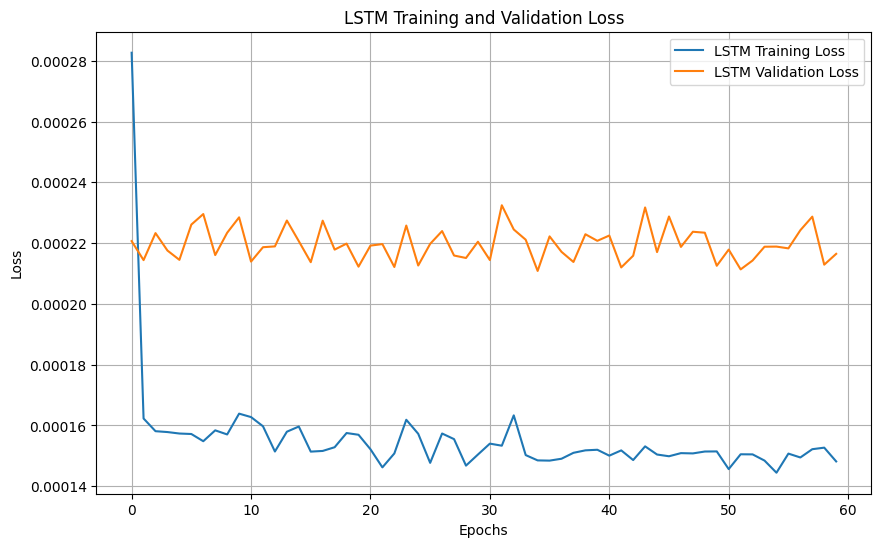

In [ ]:
# Training curve
plt.figure(figsize=(10, 6))
plt.plot(train_losses_lstm, label='LSTM Training Loss')
plt.plot(val_losses_lstm, label='LSTM Validation Loss')
plt.xlabel('Epochs'); plt.ylabel('Loss'); plt.title('LSTM Training and Validation Loss'); plt.legend(); plt.grid(True)
plt.savefig('lstm_training_curves.png'); plt.show()

#### Evaluate the LSTM

In [ ]:
lstm_model_final.load_state_dict(torch.load('best_lstm_model.pt'))

pred_returns_lstm_test = get_predicted_returns(lstm_model_final, test_loader, DEVICE)
true_returns_lstm_test = get_true_returns(test_loader)

predicted_prices_lstm_test, true_prices_lstm_test = reconstruct_prices(
    pred_returns_lstm_test,
    test_sequences # Raw unnormalized sequences for the test set
)

mse_price_lstm = MSE(true_prices_lstm_test, predicted_prices_lstm_test)
mpa_price_lstm = MPA(true_prices_lstm_test, predicted_prices_lstm_test)
mda_price_lstm = calculate_mda(true_prices_lstm_test, predicted_prices_lstm_test)

print("\nLSTM Test Metrics (on Reconstructed Prices):")
print(f"MSE (Price): {mse_price_lstm:.4f}")
print(f"MPA (Price): {mpa_price_lstm:.4f}")
print(f"MDA (Price): {mda_price_lstm:.2f}%")


LSTM Test Metrics (on Reconstructed Prices):
MSE (Price): 16.4771
MPA (Price): 0.9939
MDA (Price): 53.01%


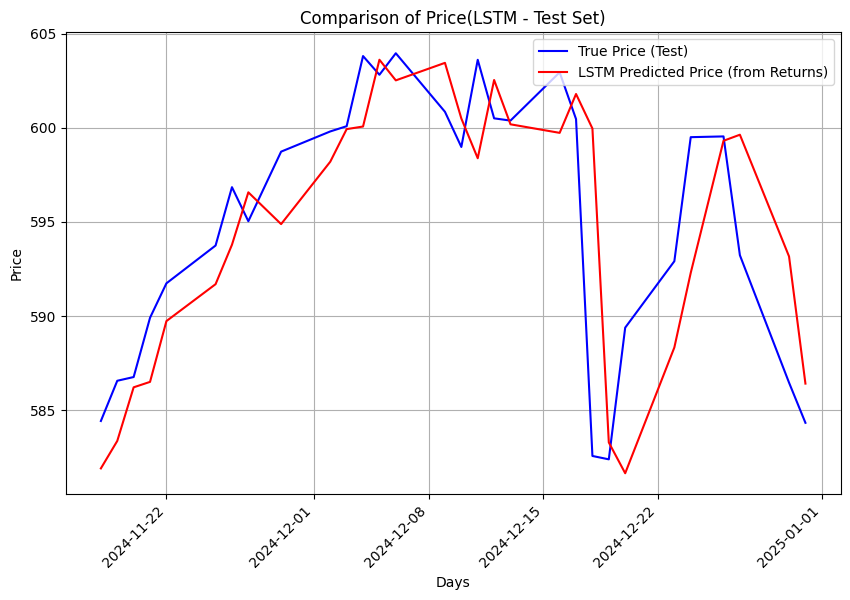

In [ ]:
num_test_days = 30 #len(y_test_denorm)
x = df.loc[i_split:, 'Date'].tolist()[-num_test_days:] # gets the corresponding test dates

# Create the plot
plt.figure(figsize=(10, 6))  # Set figure size
plt.plot(x, true_prices_lstm_test[-num_test_days:], label='True Price (Test)', color='blue')
plt.plot(x, predicted_prices_lstm_test[-num_test_days:], label='LSTM Predicted Price (from Returns)', color='red')
plt.xticks(rotation=45, ha='right')

plt.title('Comparison of Price(LSTM - Test Set)')
plt.xlabel('Days')
plt.ylabel('Price')
plt.grid(True)
plt.legend()

plt.show()

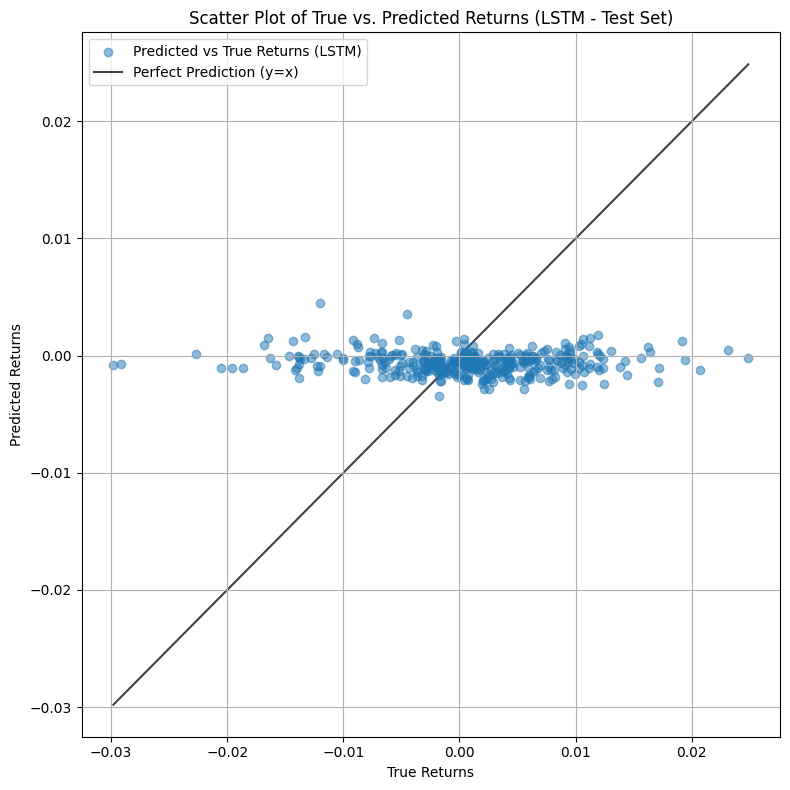

In [ ]:
true_returns_lstm_test = np.array(true_returns_lstm_test).flatten()
pred_returns_lstm_test = np.array(pred_returns_lstm_test).flatten()

plt.figure(figsize=(8, 8))
plt.scatter(true_returns_lstm_test, pred_returns_lstm_test, alpha=0.5, label='Predicted vs True Returns (LSTM)')

# Add a line for perfect correlation (y=x)
lims = [
    min(min(true_returns_lstm_test), min(pred_returns_lstm_test)),  # min of both axes
    max(max(true_returns_lstm_test), max(pred_returns_lstm_test))   # max of both axes
]
plt.plot(lims, lims, 'k-', alpha=0.75, zorder=0, label='Perfect Prediction (y=x)')

plt.xlabel("True Returns")
plt.ylabel("Predicted Returns")
plt.title("Scatter Plot of True vs. Predicted Returns (LSTM - Test Set)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ENSEMBLE

In [ ]:
# Get predictions from individual models on the validation set
# These predictions will be in terms of "returns"
transformer.eval()
lstm_model_final.eval()

val_pred_returns_transformer = []
val_pred_returns_lstm = []
val_true_returns = []
val_raw_sequences_for_reconstruction = []

with torch.no_grad():
    for inputs_val, targets_val_ret in val_loader:
        inputs_val = inputs_val.to(DEVICE)

        # Transformer predictions
        outputs_transformer_val = transformer(inputs_val)
        val_pred_returns_transformer.extend(outputs_transformer_val.cpu().numpy())

        # LSTM predictions
        outputs_lstm_val = lstm_model_final(inputs_val)
        val_pred_returns_lstm.extend(outputs_lstm_val.cpu().numpy())

        val_true_returns.extend(targets_val_ret.cpu().numpy())

val_pred_returns_transformer = np.array(val_pred_returns_transformer)
val_pred_returns_lstm = np.array(val_pred_returns_lstm)
val_true_returns = np.array(val_true_returns)

# Reconstruct prices on the validation set
val_predicted_prices_transformer, val_true_prices = reconstruct_prices(
    val_pred_returns_transformer,
    val_sequences # Raw unnormalized sequences for the validation set
)
val_predicted_prices_lstm, _ = reconstruct_prices(
    val_pred_returns_lstm,
    val_sequences
)

# Grid‐search the best weight on VALIDATION set reconstructed prices
# Using MSE as the metric
weights = np.linspace(0, 1, 101)  # Test weights from 0 to 1 for the Transformer
val_mse_ensemble = []

for w_transformer in weights:
    w_lstm = 1 - w_transformer
    ensemble_val_prices = w_transformer * val_predicted_prices_transformer + w_lstm * val_predicted_prices_lstm
    mse = np.mean((ensemble_val_prices - val_true_prices)**2)
    val_mse_ensemble.append(mse)

val_mse_ensemble = np.array(val_mse_ensemble)
best_w_transformer = weights[np.argmin(val_mse_ensemble)]
best_w_lstm = 1 - best_w_transformer

print(f"Best weight for Transformer: {best_w_transformer:.2f}")
print(f"Best weight for LSTM: {best_w_lstm:.2f}")
print(f"Achieved Validation MSE (on prices) for ensemble: {val_mse_ensemble.min():.4f}")

# Get predictions from individual models on the TEST set
test_pred_returns_transformer = []
test_pred_returns_lstm = []
test_true_returns = []

with torch.no_grad():
    for inputs_test, targets_test_ret in test_loader:
        inputs_test = inputs_test.to(DEVICE)

        outputs_transformer_test = transformer(inputs_test)
        test_pred_returns_transformer.extend(outputs_transformer_test.cpu().numpy())

        outputs_lstm_test = lstm_model_final(inputs_test)
        test_pred_returns_lstm.extend(outputs_lstm_test.cpu().numpy())

        test_true_returns.extend(targets_test_ret.cpu().numpy())

test_pred_returns_transformer = np.array(test_pred_returns_transformer)
test_pred_returns_lstm = np.array(test_pred_returns_lstm)
test_true_returns = np.array(test_true_returns)

# Reconstruct prices on the TEST set
test_predicted_prices_transformer, test_true_prices = reconstruct_prices(
    test_pred_returns_transformer,
    test_sequences
)
test_predicted_prices_lstm, _ = reconstruct_prices( # True prices are the same
    test_pred_returns_lstm,
    test_sequences
)

# Build the ensemble prediction on TEST set prices and evaluate
ensemble_test_prices = best_w_transformer * test_predicted_prices_transformer + best_w_lstm * test_predicted_prices_lstm

# Calculate metrics for the ensemble on reconstructed prices
mse_price_ensemble = MSE(test_true_prices, ensemble_test_prices)
mpa_price_ensemble = MPA(test_true_prices, ensemble_test_prices)
mda_price_ensemble = calculate_mda(test_true_prices, ensemble_test_prices)
mae_price_ensemble = np.mean(np.abs(ensemble_test_prices - test_true_prices)) # MAE

print("\nEnsemble Model Test Metrics (on Reconstructed Prices):")
print(f"MSE (Price): {mse_price_ensemble:.4f}")
print(f"MPA (Price): {mpa_price_ensemble:.4f}")
print(f"MDA (Price): {mda_price_ensemble:.2f}%")

Best weight for Transformer: 0.13
Best weight for LSTM: 0.87
Achieved Validation MSE (on prices) for ensemble: 27.4452

Ensemble Model Test Metrics (on Reconstructed Prices):
MSE (Price): 16.3495
MPA (Price): 0.9939
MDA (Price): 52.73%


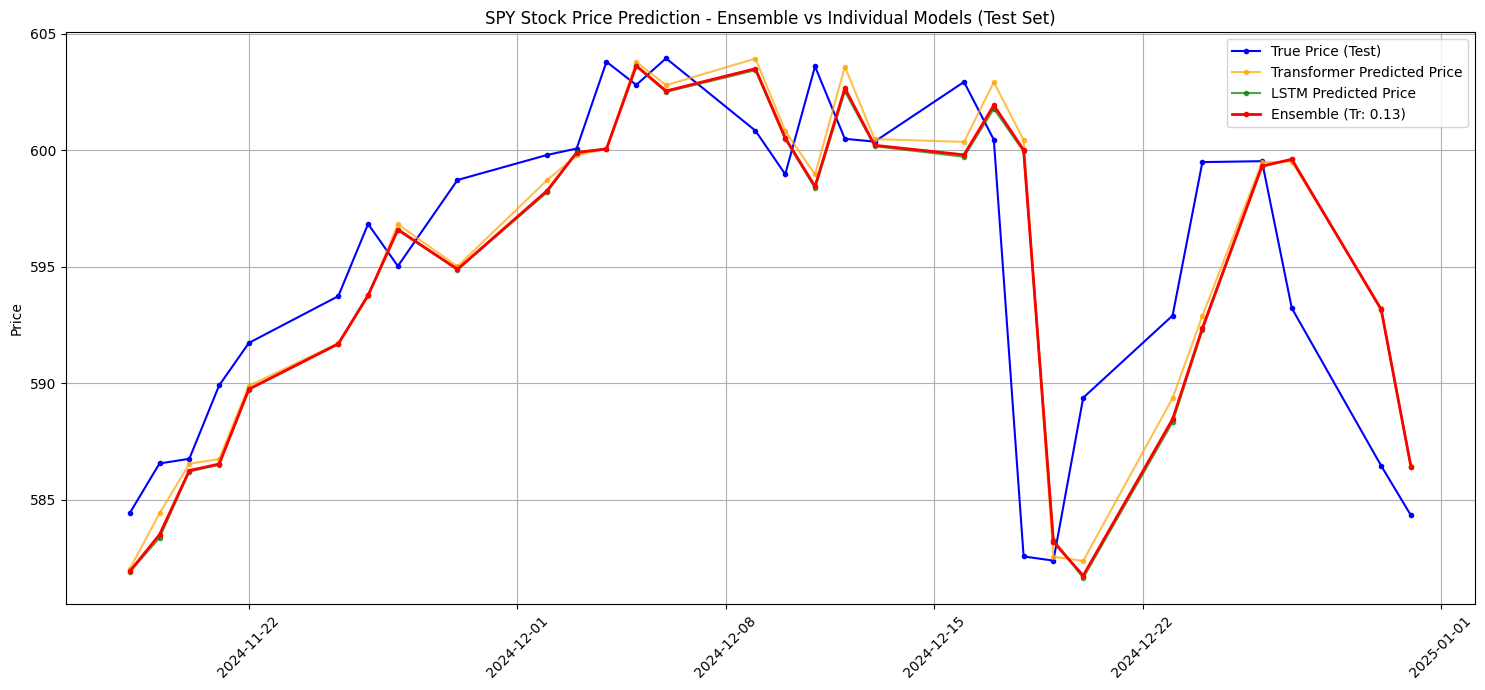


Performance Summary (Test Set Prices)
Transformer -> MSE: 15.7638, MPA: 0.9941, MDA: 53.28%
LSTM        -> MSE: 16.4771, MPA: 0.9939, MDA: 53.01%
Ensemble    -> MSE: 16.3495, MPA: 0.9939, MDA: 52.73%


In [ ]:

num_plot_days = min(30, len(test_true_prices))

plt.figure(figsize=(15, 7))
dates_to_plot = df.loc[i_split:, 'Date'].tolist()[-num_test_days:] # gets the corresponding test dates
plt.plot(dates_to_plot, test_true_prices[-num_plot_days:], label='True Price (Test)', marker='.', color='blue')
plt.plot(dates_to_plot, test_predicted_prices_transformer[-num_plot_days:], label='Transformer Predicted Price', marker='.', alpha=0.7, color='orange')
plt.plot(dates_to_plot, test_predicted_prices_lstm[-num_plot_days:], label='LSTM Predicted Price', marker='.', alpha=0.7, color='green')
plt.plot(dates_to_plot, ensemble_test_prices[-num_plot_days:], label=f'Ensemble (Tr: {best_w_transformer:.2f})', marker='.', color='red', linewidth=2)
plt.xticks(rotation=45)

plt.ylabel('Price')
plt.title(f'{ticker} Stock Price Prediction - Ensemble vs Individual Models (Test Set)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('ensemble_predictions.png')
plt.show()

# Comparison Printout
print("\nPerformance Summary (Test Set Prices)")
print(f"Transformer -> MSE: {MSE(test_true_prices, test_predicted_prices_transformer):.4f}, MPA: {MPA(test_true_prices, test_predicted_prices_transformer):.4f}, MDA: {calculate_mda(test_true_prices, test_predicted_prices_transformer):.2f}%")
print(f"LSTM        -> MSE: {MSE(test_true_prices, test_predicted_prices_lstm):.4f}, MPA: {MPA(test_true_prices, test_predicted_prices_lstm):.4f}, MDA: {calculate_mda(test_true_prices, test_predicted_prices_lstm):.2f}%")
print(f"Ensemble    -> MSE: {mse_price_ensemble:.4f}, MPA: {mpa_price_ensemble:.4f}, MDA: {mda_price_ensemble:.2f}%")